In [223]:
import numpy as np
import pandas as pd
import torch

# LogME

In [224]:
import warnings
from tqdm import tqdm
import numpy as np
from numba import njit


@njit
def each_evidence(y_, f, fh, v, s, vh, N, D):
    """
    compute the maximum evidence for each class
    """
    epsilon = 1e-5
    alpha = 1.0
    beta = 1.0
    lam = alpha / beta
    tmp = (vh @ (f @ np.ascontiguousarray(y_)))
    for _ in range(11):
        # should converge after at most 10 steps
        # typically converge after two or three steps
        gamma = (s / (s + lam)).sum()
        # A = v @ np.diag(alpha + beta * s) @ v.transpose() # no need to compute A
        # A_inv = v @ np.diag(1.0 / (alpha + beta * s)) @ v.transpose() # no need to compute A_inv
        m = v @ (tmp * beta / (alpha + beta * s))
        alpha_de = (m * m).sum()
        alpha = gamma / (alpha_de + epsilon)
        beta_de = ((y_ - fh @ m) ** 2).sum()
        beta = (N - gamma) / (beta_de + epsilon)
        new_lam = alpha / beta
        if np.abs(new_lam - lam) / lam < 0.01:
            break
        lam = new_lam
    evidence = D / 2.0 * np.log(alpha) \
               + N / 2.0 * np.log(beta) \
               - 0.5 * np.sum(np.log(alpha + beta * s)) \
               - beta / 2.0 * (beta_de + epsilon) \
               - alpha / 2.0 * (alpha_de + epsilon) \
               - N / 2.0 * np.log(2 * np.pi)
    return evidence / N, alpha, beta, m


# use pseudo data to compile the function
# D = 20, N = 50
f_tmp = np.random.randn(20, 50).astype(np.float64)
each_evidence(np.random.randint(0, 2, 50).astype(np.float64), f_tmp, f_tmp.transpose(), np.eye(20, dtype=np.float64), np.ones(20, dtype=np.float64), np.eye(20, dtype=np.float64), 50, 20)


@njit
def truncated_svd(x):
    u, s, vh = np.linalg.svd(x.transpose() @ x)
    s = np.sqrt(s)
    u_times_sigma = x @ vh.transpose()
    k = np.sum((s > 1e-10) * 1)  # rank of f
    s = s.reshape(-1, 1)
    s = s[:k]
    vh = vh[:k]
    u = u_times_sigma[:, :k] / s.reshape(1, -1)
    return u, s, vh
truncated_svd(np.random.randn(20, 10).astype(np.float64))


class LogME(object):
    def __init__(self, regression=False):
        """
            :param regression: whether regression
        """
        self.regression = regression
        self.fitted = False
        self.reset()

    def reset(self):
        self.num_dim = 0
        self.alphas = []  # alpha for each class / dimension
        self.betas = []  # beta for each class / dimension
        # self.ms.shape --> [C, D]
        self.ms = []  # m for each class / dimension

    def _fit_icml(self, f: np.ndarray, y: np.ndarray):
        """
        LogME calculation proposed in the ICML 2021 paper
        "LogME: Practical Assessment of Pre-trained Models for Transfer Learning"
        at http://proceedings.mlr.press/v139/you21b.html
        """
        fh = f
        f = f.transpose()
        D, N = f.shape
        v, s, vh = np.linalg.svd(f @ fh, full_matrices=True)

        evidences = []
        self.num_dim = y.shape[1] if self.regression else int(y.max() + 1)
        for i in tqdm(range(self.num_dim)):
            y_ = y[:, i] if self.regression else (y == i).astype(np.float64)
            evidence, alpha, beta, m = each_evidence(y_, f, fh, v, s, vh, N, D)
            evidences.append(evidence)
            self.alphas.append(alpha)
            self.betas.append(beta)
            self.ms.append(m)
        self.ms = np.stack(self.ms)
        return np.mean(evidences)

    def _fit_fixed_point(self, f: np.ndarray, y: np.ndarray):
        """
        LogME calculation proposed in the arxiv 2021 paper
        "Ranking and Tuning Pre-trained Models: A New Paradigm of Exploiting Model Hubs"
        at https://arxiv.org/abs/2110.10545
        """
        N, D = f.shape  # k = min(N, D)
        if N > D: # direct SVD may be expensive
            u, s, vh = truncated_svd(f)
        else:
            u, s, vh = np.linalg.svd(f, full_matrices=False)
        # u.shape = N x k
        # s.shape = k
        # vh.shape = k x D
        s = s.reshape(-1, 1)
        sigma = (s ** 2)

        evidences = []
        self.num_dim = y.shape[1] if self.regression else int(y.max() + 1)
        for i in range(self.num_dim):
            y_ = y[:, i] if self.regression else (y == i).astype(np.float64)
            y_ = y_.reshape(-1, 1)
            x = u.T @ y_  # x has shape [k, 1], but actually x should have shape [N, 1]
            x2 = x ** 2
            res_x2 = (y_ ** 2).sum() - x2.sum()  # if k < N, we compute sum of xi for 0 singular values directly

            alpha, beta = 1.0, 1.0
            for _ in range(11):
                t = alpha / beta
                gamma = (sigma / (sigma + t)).sum()
                m2 = (sigma * x2 / ((t + sigma) ** 2)).sum()
                res2 = (x2 / ((1 + sigma / t) ** 2)).sum() + res_x2
                alpha = gamma / (m2 + 1e-5)
                beta = (N - gamma) / (res2 + 1e-5)
                t_ = alpha / beta
                evidence = D / 2.0 * np.log(alpha) \
                           + N / 2.0 * np.log(beta) \
                           - 0.5 * np.sum(np.log(alpha + beta * sigma)) \
                           - beta / 2.0 * res2 \
                           - alpha / 2.0 * m2 \
                           - N / 2.0 * np.log(2 * np.pi)
                evidence /= N
                if abs(t_ - t) / t <= 1e-3:  # abs(t_ - t) <= 1e-5 or abs(1 / t_ - 1 / t) <= 1e-5:
                    break
            evidence = D / 2.0 * np.log(alpha) \
                       + N / 2.0 * np.log(beta) \
                       - 0.5 * np.sum(np.log(alpha + beta * sigma)) \
                       - beta / 2.0 * res2 \
                       - alpha / 2.0 * m2 \
                       - N / 2.0 * np.log(2 * np.pi)
            evidence /= N
            m = 1.0 / (t + sigma) * s * x
            m = (vh.T @ m).reshape(-1)
            evidences.append(evidence)
            self.alphas.append(alpha)
            self.betas.append(beta)
            self.ms.append(m)
        self.ms = np.stack(self.ms)
        return np.mean(evidences)

    _fit = _fit_fixed_point

    def fit(self, f: np.ndarray, y: np.ndarray):
        """
        :param f: [N, F], feature matrix from pre-trained model
        :param y: target labels.
            For classification, y has shape [N] with element in [0, C_t).
            For regression, y has shape [N, C] with C regression-labels
        :return: LogME score (how well f can fit y directly)
        """
        if self.fitted:
            warnings.warn('re-fitting for new data. old parameters cleared.')
            self.reset()
        else:
            self.fitted = True
        f = f.astype(np.float64)
        if self.regression:
            y = y.astype(np.float64)
            if len(y.shape) == 1:
                y = y.reshape(-1, 1)
        return self._fit(f, y)

    def predict(self, f: np.ndarray):
        """
        :param f: [N, F], feature matrix
        :return: prediction, return shape [N, X]
        """
        if not self.fitted:
            raise RuntimeError("not fitted, please call fit first")
        f = f.astype(np.float64)
        logits = f @ self.ms.T
        if self.regression:
            return logits
        return np.argmax(logits, axis=-1)

In [225]:
import pickle
with open("/content/drive/MyDrive/LogME-CTC/PR_hubert_ranking_layer_0.pkl", "rb") as fp:   # Unpickling
 pickle_feature = pickle.load(fp)
sample_feature = pickle_feature[0][0].cpu().numpy()
sample_feature.shape # the feature of sample 1

(1695, 768)

In [226]:
log_prob = np.load("/content/drive/MyDrive/LogME-CTC/PR_log_prob_sample1.npy")
torch.from_numpy(log_prob).transpose(0,1)[0].shape
log_prob = torch.from_numpy(log_prob).transpose(0,1).argmax(dim=-1).numpy()[0]
log_prob[:50]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       11,  0,  0, 59, 59,  0, 60, 60, 60, 60, 43, 43,  0,  0,  0, 11, 11,
        0,  0,  0,  0, 70, 70, 34, 34,  0,  0, 61, 61,  0, 39,  0,  0])

In [227]:
label_lst = [11, 59, 60, 43, 11, 70, 34, 61, 11, 25, 38, 30, 37, 28, 59, 61, 59, 60,
        43, 59, 30, 69, 34, 25, 62, 61, 34, 23, 11, 47, 70, 40, 62, 23, 52, 62,
        59,  9, 61, 11, 59, 36,  9, 46, 60, 11, 49,  9, 49, 25, 25, 39, 59, 46,
        70, 21, 11, 61, 68, 25, 36, 15, 58, 38, 30, 59, 52, 60, 11, 47, 36, 12,
        50, 46, 60, 11, 49, 72, 70, 31, 36, 71, 67, 61, 11, 49, 21, 61, 26, 28,
        58, 70, 31, 60, 43, 24, 28, 46, 61, 26, 11, 48, 15, 36, 15, 49, 38, 30,
        36, 40, 50, 37, 30, 72, 59, 40, 58, 45, 34, 48, 72, 46, 58, 34, 61, 11,
        49, 62, 58, 40, 24, 40, 50, 37, 47, 39, 60, 48, 10, 49, 71, 11, 36,  9,
        46, 24, 30, 30,  9, 49, 25, 47, 34, 25, 42, 46, 58, 34, 61, 11, 49, 48,
        40, 59, 61, 30,  9, 49, 25, 48, 40, 59, 39, 72, 69,  9, 49, 25, 30, 57,
        68, 47, 48, 40, 59, 61, 30, 38,  9, 58, 42, 46, 58, 28, 59, 70, 29, 47,
         9, 49, 25, 38, 39, 59, 59, 40, 59, 61, 30, 45,  6, 49, 61, 34, 47, 30,
         9, 49, 25, 38, 39, 59, 59, 40, 59, 61, 30,  9, 49, 25, 48, 40, 59, 61,
        30, 24,  6, 58, 11, 47, 72, 59, 48, 41, 62, 38, 67, 48, 62, 43, 69, 49,
        39, 50, 57, 34, 57, 30, 72, 48, 28, 49, 60, 11, 49, 25, 11, 59, 47, 21,
        46, 47, 42, 61, 51, 23, 42, 71, 66, 49, 21, 61, 39, 25, 59, 61, 34, 61,
        59, 59, 28, 49, 11, 61, 30, 36, 58, 12, 48, 49, 67, 45, 31, 72, 42, 11,
        59, 11, 47, 28, 46, 60, 11, 49, 12, 69, 37, 28, 59, 61, 59, 26,  9, 61,
        38,  9, 25, 23, 11, 49, 25, 39, 61, 31, 48, 11, 49, 25, 11, 49, 49, 52,
        49, 61, 51, 62, 38, 52, 59, 61, 11, 59, 23, 21, 62, 48, 43, 61, 39, 50,
        12, 69, 46,  6, 61, 11, 49, 40, 49, 61, 58, 11, 59, 61, 59, 31, 47, 42,
        30, 39, 49, 62, 25, 34,  1]
label_set = list(set(label_lst))
print(label_set[:50])

[1, 6, 9, 10, 11, 12, 15, 21, 23, 24, 25, 26, 28, 29, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 57, 58, 59, 60, 61, 62, 66, 67, 68, 69, 70, 71, 72]


In [228]:
#for label in label_set:
label = label_set[0]
feat_index = np.where(log_prob == label)[0]
feat_index, label

(array([1692, 1693, 1694]), 1)

In [229]:
sample_feature.shape
label
log_prob[:50]
label = 11
feat_index = np.where(log_prob == label)[0]
sample_feature[feat_index].shape

(36, 768)

In [230]:
np.where(log_prob == 11), log_prob[:50]

((array([  17,   32,   33,  123,  124,  169,  170,  194,  239,  292,  293,
          313,  441,  569,  703,  704, 1189, 1190, 1197, 1256, 1257, 1285,
         1356, 1365, 1366, 1381, 1425, 1448, 1449, 1461, 1510, 1511, 1583,
         1584, 1603, 1604]),),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        11,  0,  0, 59, 59,  0, 60, 60, 60, 60, 43, 43,  0,  0,  0, 11, 11,
         0,  0,  0,  0, 70, 70, 34, 34,  0,  0, 61, 61,  0, 39,  0,  0]))

# Observations of the alignments
## when the label is 11
* 單獨一個frame[169]: 4116.7936, 大部分都是4XXX多
* 第32/33個frame predict出來的score相加: 2130.057
* 第123/124個frame predict出來的score相加: 2129.4805
* 第169/170個frame predict出來的score相加: 2131.3746

## when the label is 60
* 四個frame ([23,24,25,26])的score是1172
* 三個frame ([75, 76, 77])的score是1519
* 23 ==> 4439.9755



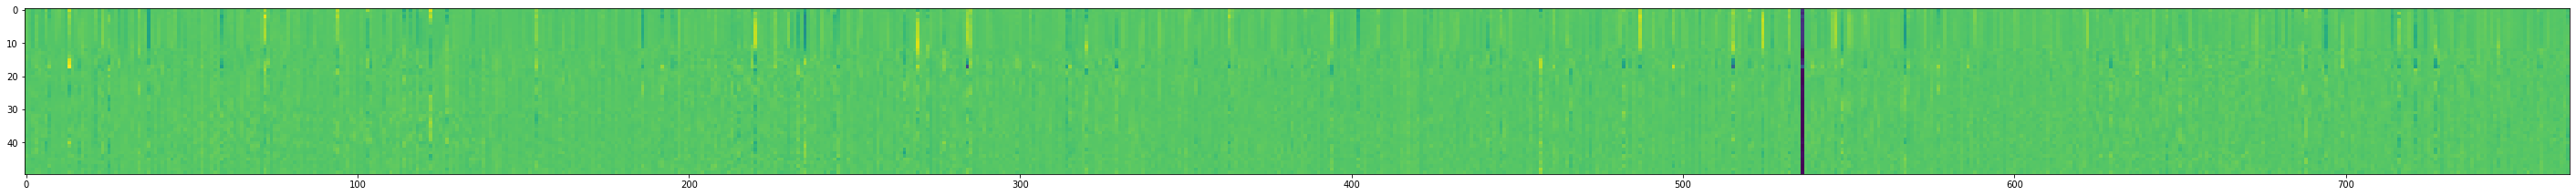

In [231]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (50,15))
plt.imshow(sample_feature[:50],interpolation='nearest')
plt.show()

In [232]:
sample_feature[0].shape

(768,)

In [237]:
#np.concatenate((a, b), axis=None)
sample_feature[[23, 24, 25, 26]].shape
feature = np.array([np.concatenate((sample_feature[23],sample_feature[24],sample_feature[25],sample_feature[26]))])

In [235]:
#framewise
label = 60
feat_index = np.where(log_prob == label)[0]
print(len(feat_index))

feat_index = np.where(log_prob == label)[0]
logme = LogME(regression=False)
score = logme._fit_fixed_point(sample_feature[[23, 24, 25, 26]], np.array([60] * 4))
print(label, score)
  
# 一個feature算一個score應該會不準吧
# 發現不同的feature size出來會有不同的logme score，當feature 餵進去的size越小，出來的logme score越大

# 每一個不同的phonene prediction出來的scale會有一點點不同

23
60 1172.3016038978526


In [236]:
from tqdm import tqdm
layer_num = 0
for layer_num in range(12):
  with open(f"/content/drive/MyDrive/LogME-CTC/PR_hubert_ranking_layer_{layer_num}.pkl", "rb") as fp:   # Unpickling
    pickle_feature = pickle.load(fp)
  sample_feature = pickle_feature[0][0].cpu().numpy()
  

  log_prob = np.load(f"/content/drive/MyDrive/LogME-CTC/PR_log_prob/PR_hubert_ranking_layer_{layer_num}_PR_log_prob.npy")
  log_prob = torch.from_numpy(log_prob).transpose(0,1).argmax(dim=-1).numpy()[0]
  print(np.where(log_prob == 60))
  
  logme = LogME(regression=False)
  score = logme._fit_fixed_point(sample_feature[np.where(log_prob == 60)], np.array([60] * len()))
  print(label, score)
  print("layer_num", layer_num, "  score:",score)

60 1172.3016038978526
layer_num 0   score: 1172.3016038978526
60 1163.7222590627011
layer_num 1   score: 1163.7222590627011
60 1171.408271128615
layer_num 2   score: 1171.408271128615
60 1171.408248725115
layer_num 3   score: 1171.408248725115
60 1181.7931254639998
layer_num 4   score: 1181.7931254639998
60 1181.7448647887395
layer_num 5   score: 1181.7448647887395
60 1181.6781883116248
layer_num 6   score: 1181.6781883116248
60 1182.2483014213233
layer_num 7   score: 1182.2483014213233
60 1180.1898101909878
layer_num 8   score: 1180.1898101909878
60 1178.4011323970965
layer_num 9   score: 1178.4011323970965
60 1164.3909487925748
layer_num 10   score: 1164.3909487925748
60 1162.7793599091162
layer_num 11   score: 1162.7793599091162


In [248]:
sample_feature[feat_index].reshape(1, 2 * 768).shape

(1, 1536)

In [249]:
from tqdm import tqdm
layer_num = 0
label = 60
for layer_num in range(12):
  with open(f"/content/drive/MyDrive/LogME-CTC/PR_hubert_ranking_layer_{layer_num}.pkl", "rb") as fp:   # Unpickling
    pickle_feature = pickle.load(fp)
  sample_feature = pickle_feature[0][0].cpu().numpy()
  #feature = np.array([np.concatenate((sample_feature[23],sample_feature[24],sample_feature[25],sample_feature[26]))])

  log_prob = np.load(f"/content/drive/MyDrive/LogME-CTC/PR_log_prob/PR_hubert_ranking_layer_{layer_num}_PR_log_prob.npy")
  log_prob = torch.from_numpy(log_prob).transpose(0,1).argmax(dim=-1).numpy()[0]
  
  feat_index = np.where(log_prob == label)[0][:2]
  print(feat_index)
  
  logme = LogME(regression=False)
  score = logme._fit_fixed_point(sample_feature[feat_index].reshape(1, 2 * 768), np.array([label] * 1))
  print(label, score)
  print("layer_num", layer_num, "  score:",score)

[21 22]
60 8712.155827399849
layer_num 0   score: 8712.155827399849
[21 22]
60 8584.853748186359
layer_num 1   score: 8584.853748186359
[21 22]
60 8713.827464615644
layer_num 2   score: 8713.827464615644
[23 24]
60 8710.658922891516
layer_num 3   score: 8710.658922891516
[21 22]
60 8705.42895673823
layer_num 4   score: 8705.42895673823
[21 22]
60 8703.996860204243
layer_num 5   score: 8703.996860204243
[21 22]
60 8708.73928180184
layer_num 6   score: 8708.73928180184
[23 24]
60 8714.302907236883
layer_num 7   score: 8714.302907236883
[24 25]
60 8714.162553873466
layer_num 8   score: 8714.162553873466
[24 25]
60 8716.144534678362
layer_num 9   score: 8716.144534678362
[21 22]
60 8609.680064259344
layer_num 10   score: 8609.680064259344
[21 22]
60 8589.321888016226
layer_num 11   score: 8589.321888016226


# 檢查layer0 - layer 11的Per frame score
every single frame with prediction

In [ ]:
label_lst = [11, 59, 60, 43, 11, 70, 34, 61, 11, 25, 38, 30, 37, 28, 59, 61, 59, 60,
        43, 59, 30, 69, 34, 25, 62, 61, 34, 23, 11, 47, 70, 40, 62, 23, 52, 62,
        59,  9, 61, 11, 59, 36,  9, 46, 60, 11, 49,  9, 49, 25, 25, 39, 59, 46,
        70, 21, 11, 61, 68, 25, 36, 15, 58, 38, 30, 59, 52, 60, 11, 47, 36, 12,
        50, 46, 60, 11, 49, 72, 70, 31, 36, 71, 67, 61, 11, 49, 21, 61, 26, 28,
        58, 70, 31, 60, 43, 24, 28, 46, 61, 26, 11, 48, 15, 36, 15, 49, 38, 30,
        36, 40, 50, 37, 30, 72, 59, 40, 58, 45, 34, 48, 72, 46, 58, 34, 61, 11,
        49, 62, 58, 40, 24, 40, 50, 37, 47, 39, 60, 48, 10, 49, 71, 11, 36,  9,
        46, 24, 30, 30,  9, 49, 25, 47, 34, 25, 42, 46, 58, 34, 61, 11, 49, 48,
        40, 59, 61, 30,  9, 49, 25, 48, 40, 59, 39, 72, 69,  9, 49, 25, 30, 57,
        68, 47, 48, 40, 59, 61, 30, 38,  9, 58, 42, 46, 58, 28, 59, 70, 29, 47,
         9, 49, 25, 38, 39, 59, 59, 40, 59, 61, 30, 45,  6, 49, 61, 34, 47, 30,
         9, 49, 25, 38, 39, 59, 59, 40, 59, 61, 30,  9, 49, 25, 48, 40, 59, 61,
        30, 24,  6, 58, 11, 47, 72, 59, 48, 41, 62, 38, 67, 48, 62, 43, 69, 49,
        39, 50, 57, 34, 57, 30, 72, 48, 28, 49, 60, 11, 49, 25, 11, 59, 47, 21,
        46, 47, 42, 61, 51, 23, 42, 71, 66, 49, 21, 61, 39, 25, 59, 61, 34, 61,
        59, 59, 28, 49, 11, 61, 30, 36, 58, 12, 48, 49, 67, 45, 31, 72, 42, 11,
        59, 11, 47, 28, 46, 60, 11, 49, 12, 69, 37, 28, 59, 61, 59, 26,  9, 61,
        38,  9, 25, 23, 11, 49, 25, 39, 61, 31, 48, 11, 49, 25, 11, 49, 49, 52,
        49, 61, 51, 62, 38, 52, 59, 61, 11, 59, 23, 21, 62, 48, 43, 61, 39, 50,
        12, 69, 46,  6, 61, 11, 49, 40, 49, 61, 58, 11, 59, 61, 59, 31, 47, 42,
        30, 39, 49, 62, 25, 34,  1]
label_set = list(set(label_lst))
len(label_set)

46

In [ ]:
from tqdm import tqdm
layer_num = 0
for layer_num in range(12):
  with open(f"/content/drive/MyDrive/LogME-CTC/PR_hubert_ranking_layer_{layer_num}.pkl", "rb") as fp:   # Unpickling
    pickle_feature = pickle.load(fp)
  sample_feature = pickle_feature[0][0].cpu().numpy()

  log_prob = np.load(f"/content/drive/MyDrive/LogME-CTC/PR_log_prob/PR_hubert_ranking_layer_{layer_num}_PR_log_prob.npy")
  log_prob = torch.from_numpy(log_prob).transpose(0,1).argmax(dim=-1).numpy()[0]
  
  total_len = 0
  total_score = 0
  for label in label_set:
   
    feat_index = np.where(log_prob == label)[0]
    if len(feat_index) == 0:
      continue 
    #print("===",layer_num,"===",len(feat_index))
    logme_score = 0
    for idx in feat_index:
      logme = LogME(regression=False)
      score = logme._fit_fixed_point(sample_feature[[idx]], np.array([label] * 1))
      logme_score += score
    total_score += logme_score/len(feat_index)
    total_len += 1
  print("layer_num", layer_num, "  score:",total_score/total_len, total_score, total_len)

layer_num 0   score: 4246.587586046338 169863.50344185354 40
layer_num 1   score: 4136.984048876278 173753.3300528037 42
layer_num 2   score: 4251.372805502688 174306.2850256102 41
layer_num 3   score: 4251.077791103096 178545.26722633003 42
layer_num 4   score: 4244.035100402216 178249.47421689308 42
layer_num 5   score: 4240.88077977528 186598.7543101123 44
layer_num 6   score: 4243.829723425261 182484.67810728622 43
layer_num 7   score: 4249.051850954024 182709.22959102303 43
layer_num 8   score: 4250.04795995291 182752.0622779751 43
layer_num 9   score: 4252.781213087251 187122.37337583903 44
layer_num 10   score: 4145.241977944502 174100.16307366907 42
layer_num 11   score: 4139.931146327426 173877.1081457519 42


In [ ]:
sample1_score_lst = [4246.587586046338,4136.984048876278,4251.372805502688,4251.077791103096,4244.035100402216,4240.88077977528,4243.829723425261,4249.051850954024,4250.04795995291,4252.781213087251,4145.241977944502,4139.931146327426]
len(sample1_score_lst)
sample2_score_lst = [4247.380294036029,4131.372238049568,4246.639100919552,4244.575837364068,4239.512707908129,4236.721896782044,4242.051197761734,4244.314656048208,4247.452598626103,4251.081810022576,4133.866253316534,4130.145557752629]
len(sample2_score_lst)
merge = [sample1_score_lst[i] + sample2_score_lst[i] for i in range(12)]
for score in merge:
  print(score)

8493.967880082368
8268.356286925846
8498.01190642224
8495.653628467164
8483.547808310344
8477.602676557322
8485.880921186996
8493.366507002233
8497.500558579013
8503.863023109827
8279.108231261036
8270.076704080057


In [ ]:
from scipy import stats
res = stats.spearmanr(merge,[12,9,8,7,6,5,4,3,2,1,10,11])
res

SpearmanrResult(correlation=-0.5034965034965035, pvalue=0.09515736659412469)

### sample 2

In [ ]:
label_lst = [11, 58, 44, 46, 11, 49, 59, 41, 47, 42, 34, 60, 11, 49, 23, 42, 61, 70,
        43, 49, 62, 61, 67, 46, 11, 49, 36, 47, 40, 46, 61, 39, 50, 58, 42, 46,
        70, 21, 58, 48, 11, 49, 61, 59, 40, 72, 39, 36, 28, 46, 61, 39, 25, 23,
        21, 11, 58, 42, 59, 15, 58, 61, 61, 51, 48, 34, 46, 23, 39, 47, 43, 69,
        48, 28, 49, 42,  9, 49, 25, 41, 49, 61, 58, 11, 46, 11, 61, 57, 11, 47,
        21, 61, 11, 23, 72, 31, 69, 11, 49, 59, 39, 72,  9, 49, 25, 59, 52, 60,
        11, 47, 25, 67, 61, 42, 72, 12, 69, 11, 59, 29, 58, 11, 48, 52, 49, 42,
        11, 47, 49, 34, 24, 30,  6, 58, 25, 39, 69, 28, 47, 11, 57, 61, 48, 28,
        49, 42, 15, 58, 37, 11, 49, 11, 72, 34, 60, 11, 49, 72,  6, 58, 36, 18,
        49, 25, 39, 25, 70, 40, 62, 59, 12, 48, 59, 57, 28, 60, 11, 59, 11, 23,
        45, 28, 46, 61, 12, 69, 11, 48, 43, 47, 71, 30, 34, 60, 11, 49, 27, 48,
        23,  6, 25, 42, 25, 39, 49, 26, 28, 58, 11, 36, 40, 60, 11, 47, 59, 61,
        21, 47,  9, 49, 25, 61, 21, 61, 11, 47, 26, 28, 58, 40, 72, 48, 12, 24,
        46, 12, 48, 39, 50,  9, 49, 25, 37, 52, 39, 50,  9, 49, 25, 11, 25, 43,
        47, 12, 69, 61, 15, 46, 61, 51, 62, 28, 49, 25, 26,  9, 61, 62, 61, 15,
        46, 30, 72, 48, 34, 49,  6, 61, 38, 34, 69, 11, 46, 34, 73, 11, 49, 61,
        51, 58, 39, 36, 47, 28, 46, 61, 15, 49, 38, 70, 12, 61, 40, 72, 62, 39,
        36, 28, 46, 24, 66, 11, 47, 29, 46, 11, 49,  6, 48, 39, 46, 69,  9, 47,
        71, 66, 12, 69, 26, 28, 58, 61, 58,  9, 36, 39, 46,  1]
label_set = list(set(label_lst))
len(label_set)

In [ ]:
from tqdm import tqdm
layer_num = 0
for layer_num in range(12):
  with open(f"/content/drive/MyDrive/LogME-CTC/PR_hubert_ranking_layer_{layer_num}.pkl", "rb") as fp:   # Unpickling
    pickle_feature = pickle.load(fp)
  sample_feature = pickle_feature[1][0].cpu().numpy()

  log_prob = np.load(f"/content/drive/MyDrive/LogME-CTC/PR_log_prob/pr sample 2/PR_hubert_ranking_layer_{layer_num}_PR_log_prob.npy")
  log_prob = torch.from_numpy(log_prob).transpose(0,1).argmax(dim=-1).numpy()[0]
  
  total_len = 0
  total_score = 0
  for label in label_set:
   
    feat_index = np.where(log_prob == label)[0]
    if len(feat_index) == 0:
      continue 
    #print("===",layer_num,"===",len(feat_index))
    logme_score = 0
    for idx in feat_index:
      logme = LogME(regression=False)
      score = logme._fit_fixed_point(sample_feature[[idx]], np.array([label] * 1))
      logme_score += score
    total_score += logme_score/len(feat_index)
    total_len += 1
  print("layer_num", layer_num, "  score:",total_score/total_len, total_score, total_len)

layer_num 0   score: 4247.380294036029 174142.5920554772 41
layer_num 1   score: 4131.372238049568 169386.2617600323 41
layer_num 2   score: 4246.639100919552 174112.20313770164 41
layer_num 3   score: 4244.575837364068 169783.03349456273 40
layer_num 4   score: 4239.512707908129 173820.0210242333 41
layer_num 5   score: 4236.721896782044 182179.04156162788 43
layer_num 6   score: 4242.051197761734 182408.20150375456 43
layer_num 7   score: 4244.314656048208 178261.21555402476 42
layer_num 8   score: 4247.452598626103 186887.91433954856 44
layer_num 9   score: 4251.081810022576 195549.7632610385 46
layer_num 10   score: 4133.866253316534 169488.5163859779 41
layer_num 11   score: 4130.145557752629 169335.9678678578 41


In [ ]:
label = 59
feat_index = np.where(log_prob == label)[0]
print(len(feat_index))

for label in label_set:
  feat_index = np.where(log_prob == label)[0]
  if len(feat_index) == 0:
      continue
  logme = LogME(regression=False)
  score = logme._fit_fixed_point(sample_feature[feat_index], np.array([label] * len(feat_index)))
  print(label, score)
# 一個feature算一個score應該會不準吧
# 發現不同的feature size出來會有不同的logme score，當feature 餵進去的size越小，出來的logme score越大

# 每一個不同的phonene prediction出來的scale會有一點點不同


56
1 1020.369548182051
6 1088.1510951420964
9 249.07748285208223
11 145.89620488201808
12 782.269980276406
15 787.4525327335698
21 450.8485024056677
23 546.4849041111667
24 608.0553524196022
25 302.4387891810425
26 1513.653178436279
28 321.63983435415554
30 195.8829059278649
31 611.6461142992534
34 391.3615073496954
36 288.88714505058437
37 803.771465008378
38 239.99885043790235
39 323.89484676012427
40 289.7891213957344
42 501.60213777582476
43 548.1969313700109
45 804.4175167066435
46 289.14174346174786
47 179.8152926707668
48 168.86949675570872
49 90.27206337979901
50 502.3079889470696
51 964.0648912980524
52 700.374743961034
57 1180.8198574624485
58 252.02188630488615
59 99.27810272803134
60 228.69770003040867
61 137.14481178210403
62 290.8182309127698
66 954.493731541889
67 699.3572822120418
68 2234.8879131890253
69 558.5218517839517
70 368.009227059501
71 1182.641147227224
72 503.2293309329337


In [ ]:

#label = label_set[0]

for label in label_set:
  feat_index = np.where(log_prob == label)[0]
  feat_index, label
  for idx in feat_index:
    logme = LogME(regression=False)
    score = logme._fit_fixed_point(np.array([sample_feature[idx].cpu().numpy()]), np.array([label]))